In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from far_heaa.grids_and_combinations.combination_generation import MultinaryCombinations
from far_heaa.io.json_handler import JSONHandler
from far_heaa.high_throughput.realignment_maths import get_realignment_energy
import seaborn as sns

from far_heaa.math_operations.thermo_calculations import ThermoMaths

In [33]:
system = 3
element_list = ['Cr', 'V', 'W', 'Ti', 'Ta', 'Fe', 'Mo', 'Nb', 'Zr', 'Hf']
file = JSONHandler.load_json(folder_path='./done_data/', file_name=f'{system}_add_ele_paths_total_10_BCC_wo_im')

data = JSONHandler.load_json(folder_path='../database', file_name='bokas_omegas_processed')
mol_grid_size = 5
x = np.linspace(0, 1, mol_grid_size)

results_dict = {}
miscible_keys = []
never_miscible_keys = []
possible_miscible_keys = []
tm = ThermoMaths()
throw_away = []
error_count = 0

h_alloy_list = []
h_comp_list = []
h_r_list = []
temperature_list = []
im_formation_list = []
reduction = []
with open('../database/intermetallic_database.pickle', 'rb') as handle:
	im_list = pickle.load(handle)

for key, value in file.items():
	for add_ele, temp_list in value.items():
		composition = key.split('-')
		if add_ele in composition:
			composition.remove(add_ele)
		temp_array = np.array(temp_list)
		temp_array[temp_array == -1000.0] = np.nan
		
		if np.isnan(temp_array[0]) or np.isnan(temp_array[-1]):
			continue
		
		h_alloy = 0
		im_formation = []
		
		for j in composition:
			h_alloy += data['-'.join(sorted([j, add_ele]))]['BCC']
			im_formation += [k.energy / k.composition.num_atoms for k in im_list['-'.join(sorted([j, add_ele]))] if
							 '-'.join(sorted([j, add_ele])) in im_list]
		
		h_alloy_list.append(h_alloy)
		h_r = get_realignment_energy(element_list=composition + [add_ele], lattice='BCC', data=data)
		h_r_list.append(h_r)
		h_comp = 0
		for j in list(MultinaryCombinations.create_multinary(composition, no_comb=[2]).values())[0]:
			h_comp += data[j]['BCC']
			# im_formation += [k.energy / k.composition.num_atoms for k in im_list[j] if j in im_list]
		if '-'.join(sorted(composition + [add_ele])) in im_list:
			im_formation += [k.energy / k.composition.num_atoms for k in
							 im_list['-'.join(sorted(composition + [add_ele]))]]
        
		if not im_formation:
			im_formation = 0
		h_comp_list.append(h_comp)
		im_formation_list.append(min(im_formation))
		
		alloy_temp = tm.avg_T_melt(composition=composition, mol_ratio=[1 / system] * system)
		element_temp = tm.avg_T_melt(composition=composition + [add_ele], mol_ratio=[1 / (system + 1)] * (system + 1))
		temperature_list.append(float(alloy_temp - element_temp))
		if np.isnan(temp_array[-1]):
			reduction.append(-2000 - temp_array[0])
		elif np.isnan(temp_array[0]):
			reduction.append(temp_array[-1] + 3500)
		else:
			reduction.append(temp_array[-1] - temp_array[0])

In [34]:
h_comp_list = np.array(h_comp_list)
h_alloy_list = np.array(h_alloy_list)
reduction = np.array(reduction)

In [44]:
n = 3
delta_h = (1 - 2*(n+1))*h_comp_list + (n + 1 - 1)*n*h_alloy_list

In [83]:
h_comp_cond = h_comp_list[delta_h <= 0]
h_alloy_cond = h_alloy_list[delta_h <= 0]
delta_h_cond = delta_h[delta_h <= 0]

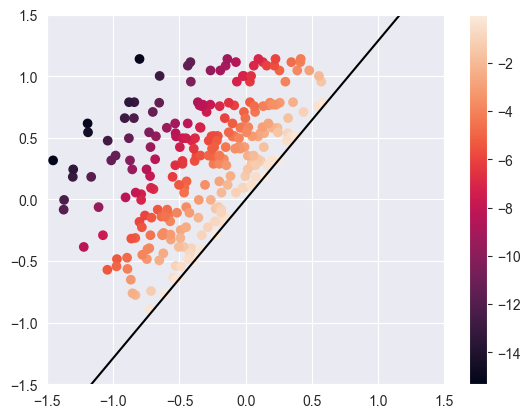

In [86]:
plt.scatter(h_alloy_cond, h_comp_cond, c = delta_h_cond)
plt.plot(np.linspace(-1.5, 1.5, 40), 9/7*np.linspace(-1.5, 1.5, 40), c='black')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.colorbar()

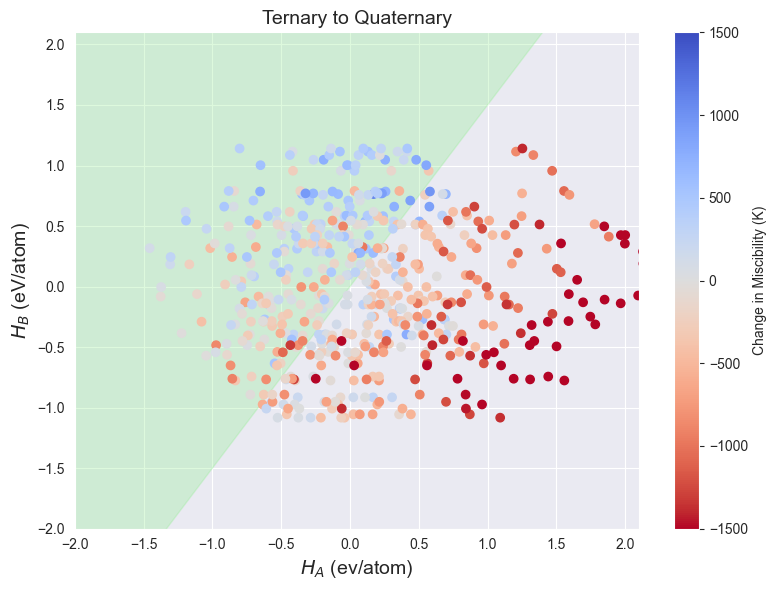

In [100]:
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot


x = np.linspace(-2, 2, 500)
y = np.linspace(-3, 3, 500)

# Second quadrant (Condition 1)
# ax.fill_betweenx(y, -2, 0, where=(y > 0), color='lightgreen', alpha=0.3, label='Condition 1: Second quadrant')

# First quadrant and third quadrant (Condition 2)
ax.fill_between(
    x, (3 / 2) * x, 3, color='lightgreen', alpha=0.3, label='abs(h_comp / h_alloy) > 3/2'
)

sc = ax.scatter(h_alloy_list, h_comp_list, c=reduction, cmap='coolwarm_r', zorder = 2, vmin = -1500, vmax = 1500)
plt.colorbar(sc, label='Change in Miscibility (K)')
# Labels and legend
ax.set_xlabel('$H_A$ (ev/atom)', fontsize=14)
ax.set_ylabel('$H_B$ (eV/atom)', fontsize=14)
ax.set_title('Ternary to Quaternary', fontsize=14)
# ax.legend(fontsize=10, loc='upper left')
ax.set_xlim(-2, 2.1)
ax.set_ylim(-2, 2.1)
plt.tight_layout()
plt.show()

In [95]:
condition1 = (h_comp_list >= 0) & (h_alloy_list <= 0)
condition2 = h_comp_list / h_alloy_list > (9/7) 
# Combined condition: Condition 1 or Condition 2
# combined_condition = condition1 | condition2
combined_condition = condition1 | condition2
num_points = np.sum(combined_condition)  # Count points satisfying the combined condition
print(f"Number of points satisfying the combined condition: {num_points}")

Number of points satisfying the combined condition: 245


In [96]:
reduction_cond = reduction[np.where(combined_condition==True)[0]]
delta_h_cond = delta_h[np.where(combined_condition==True)[0]]

In [97]:
delta_h_cond < 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False, False,  True,
        True,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False,  True,  True,
        True,  True,

In [98]:
print(np.sum(reduction_cond > 0)/ len(reduction_cond))

0.6040816326530613
